- XLOG 레코드 작성의 이해

- PostgreSQL 내부를 탐색하려면 다음 명령문을 실행



```
testdb=# INSERT INTO tbl VALUES ('A');
```

- 위 명령문을 실행하면 내부 함수 exec_simple_query()가 호출됨.

**exec_simple_query()의 의사코드**

```
exec_simple_query() @postgres.c

(1) ExtendCLOG() @clog.c                  /* Write the state of this transaction
                                           * "IN_PROGRESS" to the CLOG.
                                           */
(2) heap_insert()@heapam.c                /* Insert a tuple, creates a XLOG record,
                                           * and invoke the function XLogInsert.
                                           */
(3)   XLogInsert() @xloginsert.c (9.4 or earlier, xlog.c)
                                          /* Write the XLOG record of the inserted tuple
                                           *  to the WAL buffer, and update page's pd_lsn.
                                           */
(4) finish_xact_command() @postgres.c     /* Invoke commit action.*/   
      XLogInsert() @xloginsert.c (9.4 or earlier, xlog.c)
                                          /* Write a XLOG record of this commit action
                                           * to the WAL buffer.
                                           */
(5)   XLogWrite() @xloginsert.c (9.4 or earlier, xlog.c)
                                          /* Write and flush all XLOG records on
                                           * the WAL buffer to WAL segment.
                                           */
(6) TransactionIdCommitTree() @transam.c  /* Change the state of this transaction
                                           * from "IN_PROGRESS" to "COMMITTED"
                                           * on the CLOG.
                                           */
```

- 다음 단락에서는 XLOG 레코드 작성에 대한 이해를 돕기 위해 의사 코드의 각 줄을 설명

1. ExtendCLOG() 함수는 이 트랜잭션의 상태를 (메모리 내) CLOG에 'IN_PROGRESS'로 기록.

2. heap_insert() 함수는 공유 버퍼 풀의 대상 페이지에 힙 튜플을 삽입하고 해당 페이지에 대한 XLOG 레코드를 생성한 다음 XLogInsert() 함수를 호출.

3. XLogInsert() 함수는 heap_insert()에 의해 생성된 XLOG 레코드를 WAL 버퍼의 LSN_1에 쓴 후 수정된 페이지의 pd_lsn을 LSN_0에서 LSN_1로 업데이트.

4. 이 트랜잭션을 커밋하기 위해 호출된 함수finish_xact_command()는 커밋 작업에 대한 XLOG 레코드를 생성한 다음 XLogInsert() 함수는 이 레코드를 LSN_2의 WAL 버퍼에 씀.



**Write-sequence of XLOG records.**

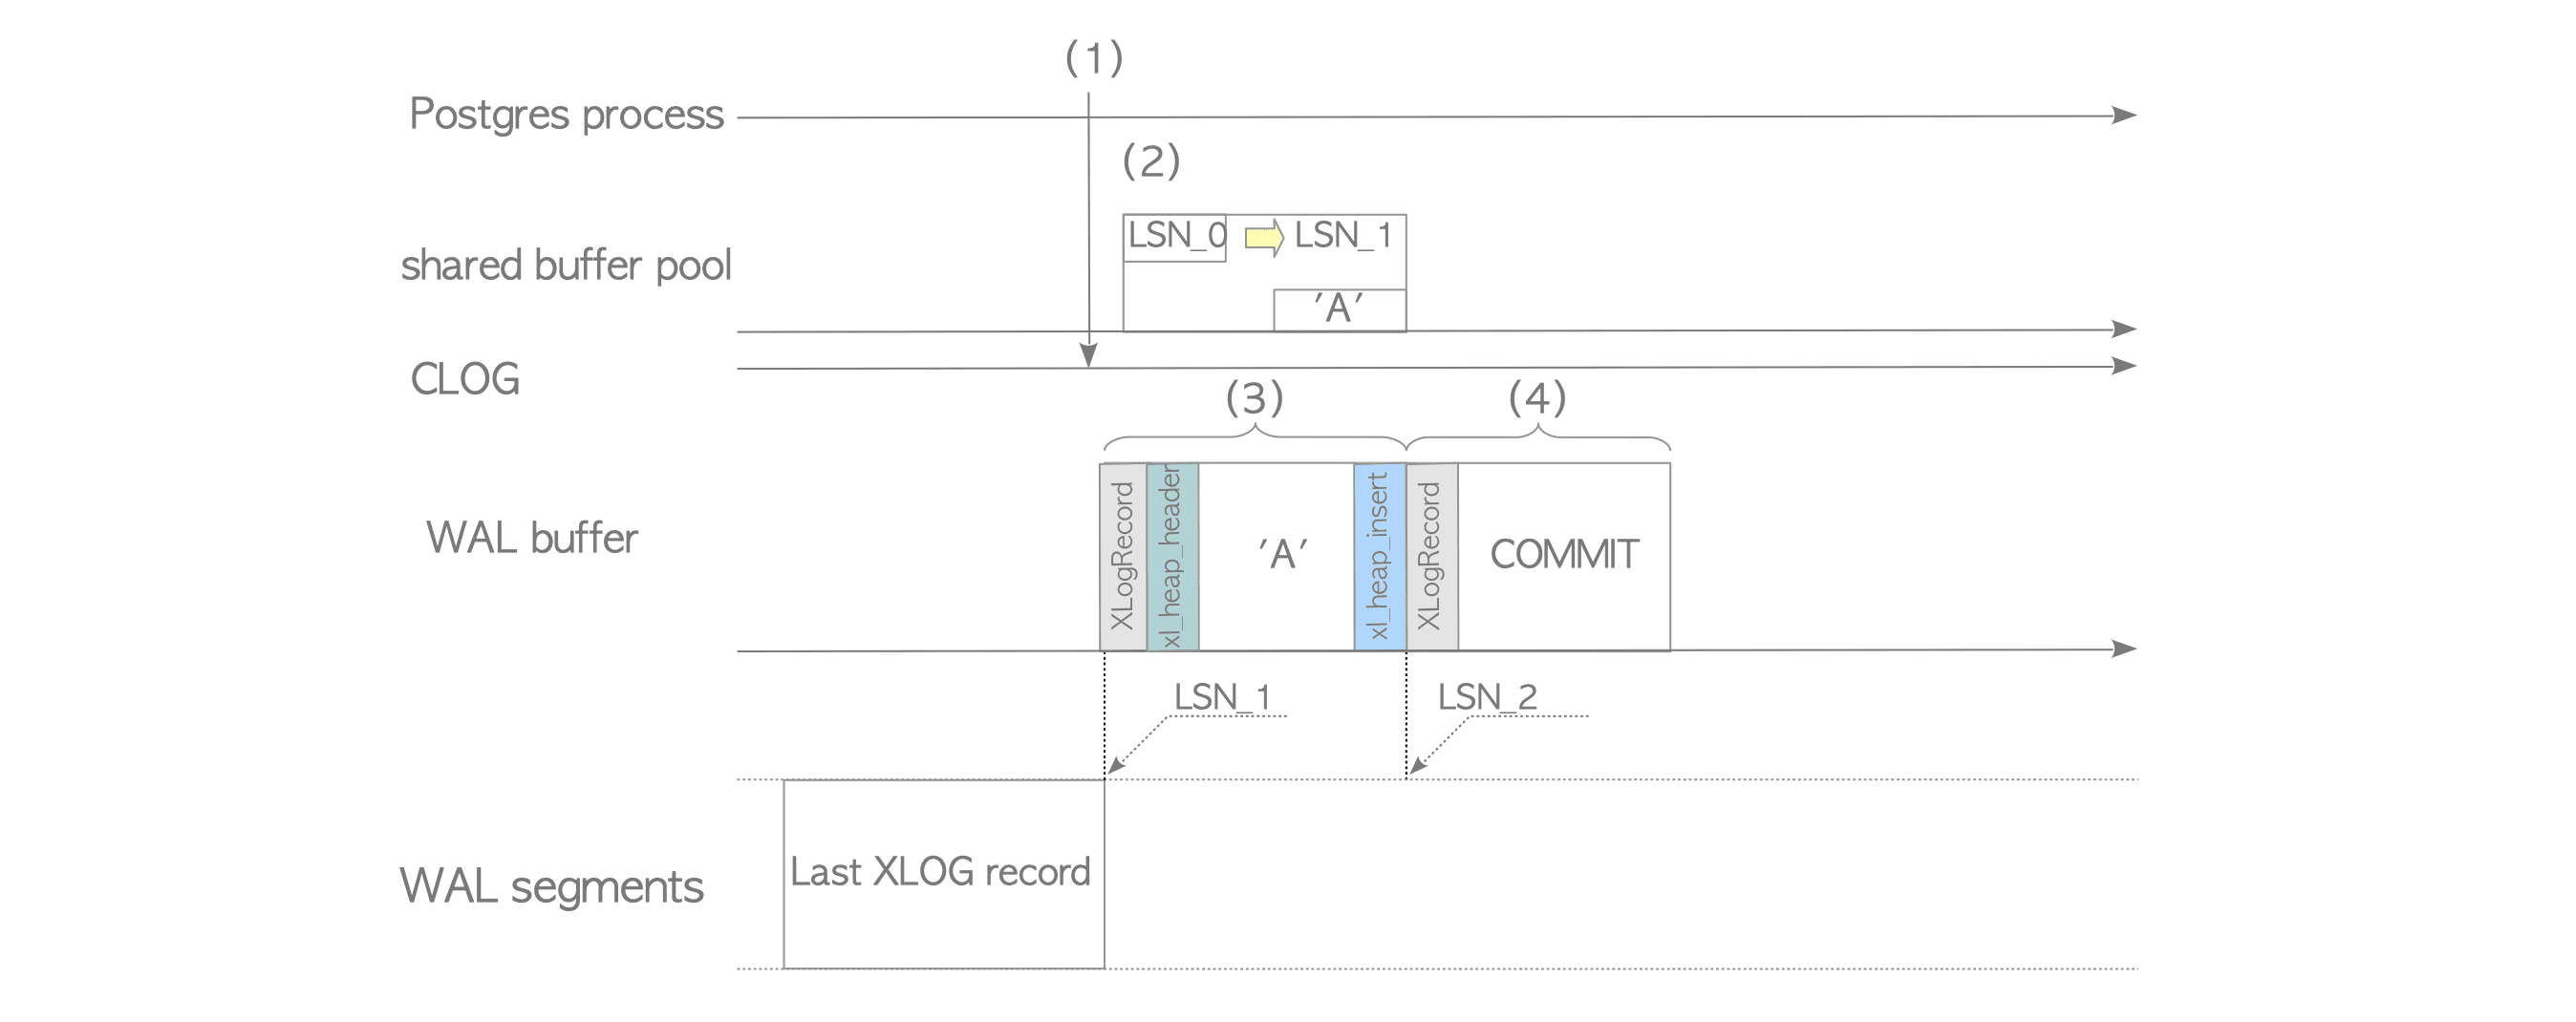

- 이러한 XLOG 레코드의 형식은 버전 9.4

5. XLogWrite() 함수는 WAL 버퍼의 모든 XLOG 레코드를 WAL 세그먼트 파일에 쓰고 플러시.
  - 매개변수 wal_sync_method가 'open_sync' 또는 'open_datasync'로 설정된 경우 함수가 'O_SYNC' 또는 'O_DSYNC' 플래그를 지정한 open() 시스템 호출을 사용하여 모든 레코드를 쓰기 때문에 레코드가 동기적으로 작성됨.
  - 매개변수가 'fsync', 'fsync_writethrough' 또는 'fdatasync'로 설정된 경우 해당 시스템 호출(fsync(), F_FULLFSYNC 옵션이 있는 fcntl() 또는 fdatasync())이 실행됨.
  - 어떠한 경우에도 모든 XLOG 레코드는 스토리지에 기록되도록 보장됨.

6. TransactionIdCommitTree() 함수는 CLOG에서 이 트랜잭션의 상태를 'IN_PROGRESS'에서 'COMMITTED'로 변경.

**Write-sequence of XLOG records.**

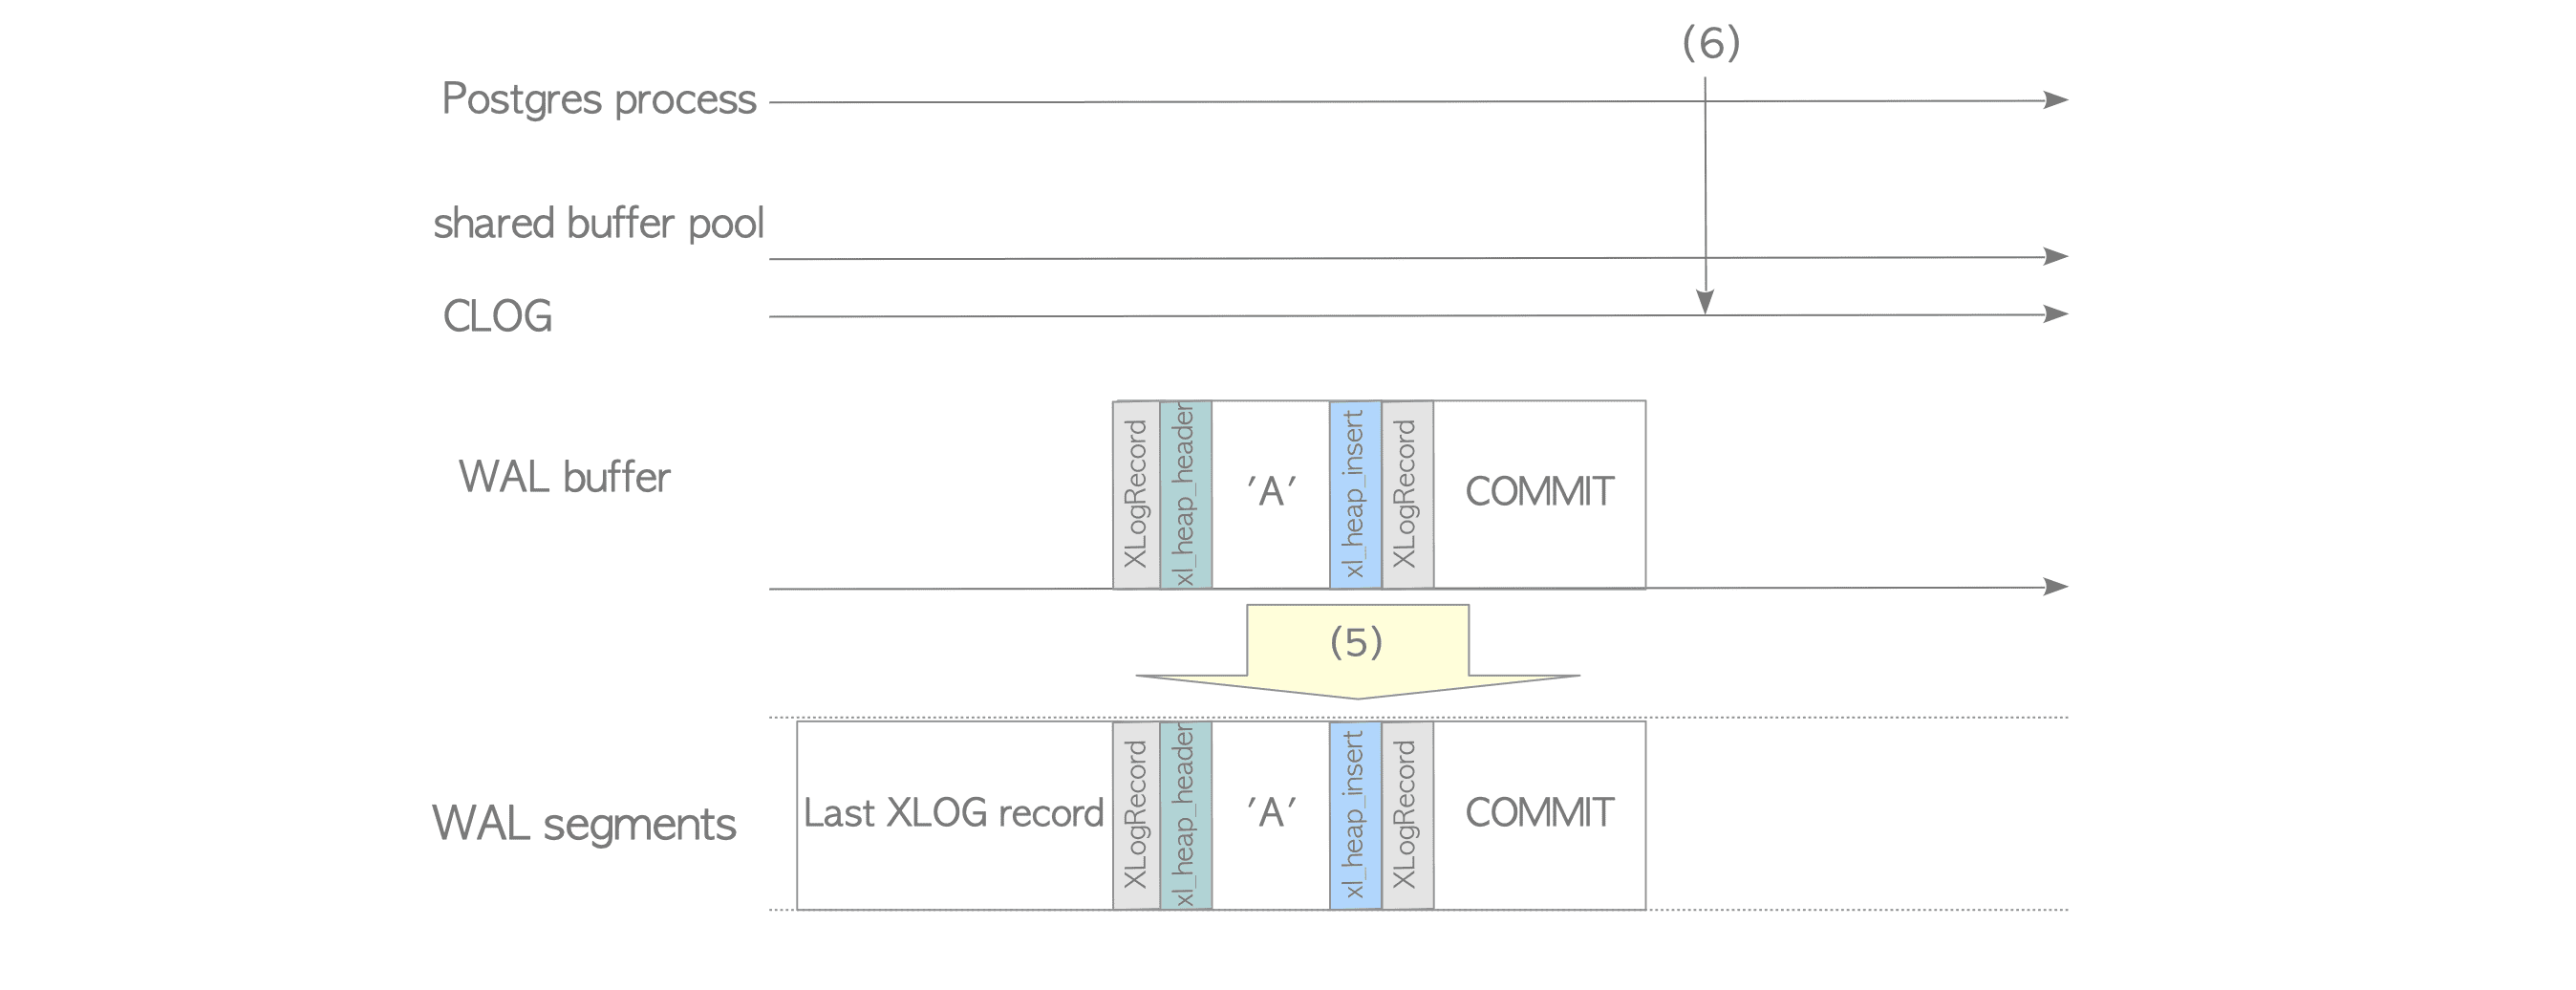

- 위의 예에서 커밋 작업으로 인해 XLOG 레코드가 WAL 세그먼트에 기록되었지만 이러한 기록은 다음 중 하나로 인해 발생할 수 있음.

1. 실행 중인 트랜잭션 하나가 커밋되거나 중단되었음.

2. WAL 버퍼가 많은 튜플로 채워졌음. (WAL 버퍼 크기는 wal_buffers 매개변수로 설정됨.)

3. WAL 작성기 프로세스는 주기적으로 씀

- 위의 상황 중 하나라도 발생하면 WAL 버퍼의 모든 WAL 레코드는 트랜잭션 커밋 여부에 관계없이 WAL 세그먼트 파일에 기록됨.

- DML(Data Manipulation Language) 작업이 XLOG 레코드를 작성하는 것은 당연하지만 비DML 작업도 마찬가지.
  - 위에서 설명한 대로 커밋 작업은 커밋된 트랜잭션의 ID를 포함하는 XLOG 레코드를 작성.
  - 또 다른 예는 체크포인트에 대한 일반 정보가 포함된 XLOG 레코드를 작성하는 체크포인트 작업.

- 또한 SELECT 문은 일반적으로 XLOG 레코드를 생성하지 않지만 특별한 경우에 XLOG 레코드를 생성.
  - 예를 들어 SELECT 문 수행 중 HOT(Heap Only Tuple)에 의해 불필요한 튜플 삭제 및 페이지 내 필요한 튜플 조각 모음이 발생하면 수정된 페이지의 XLOG 레코드가 WAL 버퍼에 기록됨.

**Direct I/O**

- PostgreSQL 버전 15 이하에서는 이미 논의되었지만 직접 I/O를 지원하지 않음.

- 버전 16에는 debug-io-direct 옵션이 추가되었음.
  - 이 옵션은 개발자가 PostgreSQL에서 직접 I/O 사용을 개선하기 위한 것.
  - 개발이 잘 진행된다면 가까운 시일 내에 Direct I/O도 공식적으로 지원될 예정.